![dsl logo](https://github.com/BrockDSL/ARCH_Data_Explore/blob/main/dsl_logo.png?raw=true)

# About
This notebook creates an Excel spreadsheet containing the first references to COVID-19 vaccines for each municipality. It also creates a visual with matplotlib. 

# Details

I was not able to programmatically find the first references using a keyword search, since the pattern "vaccine|vaccinated|vaccination" comes up too frequently. Instead I dumped all matches of this pattern, along with the **url**, **crawl_date** and **domain** into a spreadsheet and looked through the results manually. I then collected the results and created a separate worksheet with them. You can see the final result here: [https://brocku-my.sharepoint.com/:x:/g/personal/fjohnson2_brocku_ca/EUMLlNrP_IpGscaqpRmbWaoBDrvBfXkiSlrvfb3qODCUog?e=HpxYMU](https://brocku-my.sharepoint.com/:x:/g/personal/fjohnson2_brocku_ca/EUMLlNrP_IpGscaqpRmbWaoBDrvBfXkiSlrvfb3qODCUog?e=HpxYMU)

In [ ]:
!pip install xlsxwriter
import pandas as pd
import re
import requests
import xlsxwriter
from google.colab import data_table
data_table.enable_dataframe_formatter()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def download_file(url, filename=None, loud=True):
  
  if not filename:
    filename = url.split('/')[-1]
  
  r = requests.get(url, stream=True)
  if loud:
    total_bytes_dl = 0
    content_len = int(r.headers['Content-Length'])

  with open(filename, 'wb') as fd:
      for chunk in r.iter_content(chunk_size=4096):
          fd.write(chunk)
          if loud:
            total_bytes_dl += 4096
            percent = int((total_bytes_dl / content_len) * 100.0)
            print(f'\rDownload progress of {filename} {total_bytes_dl}/{content_len}: {percent}%',end='')
  r.close()

def get_muni_data():
  download_file("https://brockau.s3.us-east-2.amazonaws.com/municipal_data.csv.gz")
  !gunzip -f municipal_data.csv.gz
  archive_data = pd.read_csv("municipal_data.csv")
  archive_data.drop(columns=['Unnamed: 0', 'index', 'v_pos','v_neg','v_neu','v_comp', 'mime_type_web_server', 'mime_type_tika', 'language'], inplace=True)
  archive_data = archive_data[archive_data.content.notna()]
  archive_data.crawl_date = pd.to_datetime(archive_data.crawl_date)
  archive_data.content = archive_data.content.astype("string")
  return archive_data

In [ ]:
data = get_muni_data()

Download progress of municipal_data.csv.gz 51339264/51335494: 100%

In [ ]:
def get_matches_context(sstring):
  pattern = 'vaccine|vaccinated|vaccination'
  matches = re.finditer(pattern, sstring, flags=re.IGNORECASE)
  clen = 40 #string context length
  segments = []
  
  for i,m in enumerate(matches):
    start = max(m.start()-clen,0)
    len_left_chars = m.start() - start
    right_padding = clen - len_left_chars

    len_right_chars = min(len(sstring) - m.end(), clen)
    left_padding = clen - len_right_chars 
    padded_start = max(m.start() - (clen +left_padding), 0)
    padded_end = m.end() + clen + right_padding
    
    segments.append(bold_format)
    segments.append(f"{i}: ")
    segments.append(sstring[padded_start:m.start()])
    segments.append(enlarged_text_format)
    segments.append(sstring[m.start():m.end()])
    segments.append(sstring[m.end():padded_end])
    segments.append('\n')
    
  return segments

In [ ]:
workbook = xlsxwriter.Workbook('Vaccine first mention.xlsx')
enlarged_text_format = workbook.add_format({'bold':True,'color':'blue','font_size': 16})
bold_format = workbook.add_format({'bold':True})
header_format = workbook.add_format({'bold': True, 'center_across':True, 'bottom':True})
date_format = workbook.add_format({'num_format': 'yyyy-mm-dd','shrink':True})
text_wrap_format = workbook.add_format({'text_wrap':True})

def add_worksheet(domain, data_frame):
  worksheet = workbook.add_worksheet(domain)
  worksheet.set_column(0,0,10) #set column width to 10
  worksheet.set_column(1,1,75)
  worksheet.set_column(2,2,90,text_wrap_format)

  worksheet.write(0,0,'crawl_date',header_format)
  worksheet.write(0,1,'url',header_format)
  worksheet.write(0,2,'content',header_format)

  for i,row in enumerate(data_frame.itertuples(index=False), start=1):
    worksheet.write(i,0,row.crawl_date,date_format)
    worksheet.write(i,1,row.url)
    worksheet.write_rich_string(i,2,*get_matches_context(row.content))

for d in data.domain.drop_duplicates(): 
  specific_domain = data[(data.domain==d) & data.content.str.contains('vaccine|vaccinated|vaccination', flags=re.IGNORECASE)]
  specific_domain = specific_domain.sort_values(by=['crawl_date'],ascending=True).drop_duplicates(subset=['content'],keep='first')
  add_worksheet(d, specific_domain)

workbook.close()

/usr/local/lib/python3.7/dist-packages/xlsxwriter/worksheet.py:1275: UserWarning: Excel doesn't allow empty strings in rich strings. Ignoring input in write_rich_string().
  warn("Excel doesn't allow empty strings in rich strings. "


This next part uses the data generated in the excel sheet to chart out the first occurrences. It is adapted from https://matplotlib.org/stable/gallery/lines_bars_and_markers/timeline.html

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.text import Text
import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter()

Here's a summary of the first occurrences as a Pandas dataframe.

In [ ]:
d = {
  "date":['2020-12-11','2020-12-18','2021-01-08','2021-01-15','2021-02-05','2021-02-26','2021-03-05','2021-03-05','2021-03-05','2021-03-26','2021-05-07','2021-06-25','2021-06-25'],
  "url":['https://wayback.archive-it.org/13781/20201211212950/https://www.niagararegion.ca/health/covid-19/community-guidelines.aspx',
  'https://wayback.archive-it.org/13781/20211218005211/https://www.thorold.ca/en/city-hall/covid-19-resources.aspx',
  'https://wayback.archive-it.org/13781/20210108215910/https://notl.com/',
  'https://wayback.archive-it.org/13781/20210115214258/https://www.portcolborne.ca/Modules/News/en',
  'https://wayback.archive-it.org/13781/20210205204813/https://www.grimsby.ca/en/covid-19.aspx',
  'https://wayback.archive-it.org/13781/20210226192803/https://lincoln.ca/coronavirus-pandemic/',
  'https://wayback.archive-it.org/13781/20210305203310/https://niagarafalls.ca/covid19/default.aspx',
  'https://wayback.archive-it.org/13781/20210305192837/https://www.wainfleet.ca/en/town-hall/covid-19.aspx/',
  'https://wayback.archive-it.org/13781/20210305193211/https://www.westlincoln.ca/Modules/News/en',
  'https://wayback.archive-it.org/13781/20210326193340/https://www.welland.ca/hottopics/COVID-19.asp',
  'https://wayback.archive-it.org/13781/20210507192826/https://www.stcatharines.ca/en/livein/covid-19.asp',
  'https://wayback.archive-it.org/13781/20210625194903/https://www.forterie.ca/pages/Covid19News/',
  'https://wayback.archive-it.org/13781/20210625211413/https://www.pelham.ca/en/news/council-highlights-june-21-2021.aspx']}

pd.DataFrame(d, index=['niagararegion.ca','thorold.ca','notl.com','portcolborne.ca','grimsby.ca','lincoln.ca','niagarafalls.ca','wainfleet.ca','westlincoln.ca','welland.ca','stcatharines.ca','forterie.ca','pelham.ca'])

,date,url
niagararegion.ca,2020-12-11,https://wayback.archive-it.org/13781/202012112...
thorold.ca,2020-12-18,https://wayback.archive-it.org/13781/202112180...
notl.com,2021-01-08,https://wayback.archive-it.org/13781/202101082...
portcolborne.ca,2021-01-15,https://wayback.archive-it.org/13781/202101152...
grimsby.ca,2021-02-05,https://wayback.archive-it.org/13781/202102052...
lincoln.ca,2021-02-26,https://wayback.archive-it.org/13781/202102261...
niagarafalls.ca,2021-03-05,https://wayback.archive-it.org/13781/202103052...
wainfleet.ca,2021-03-05,https://wayback.archive-it.org/13781/202103051...
westlincoln.ca,2021-03-05,https://wayback.archive-it.org/13781/202103051...
welland.ca,2021-03-26,https://wayback.archive-it.org/13781/202103261...


In [ ]:
names = ['niagararegion.ca','thorold.ca','notl.com','portcolborne.ca','grimsby.ca','lincoln.ca','niagarafalls.ca',
          'wainfleet.ca','westlincoln.ca','welland.ca','stcatharines.ca','forterie.ca','pelham.ca',]
dates = ['2020-12-11','2020-12-18','2021-01-08','2021-01-15',
         '2021-02-05','2021-02-26','2021-03-05','2021-03-05',
         '2021-03-05','2021-03-26','2021-05-07','2021-06-25','2021-06-25']

# Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


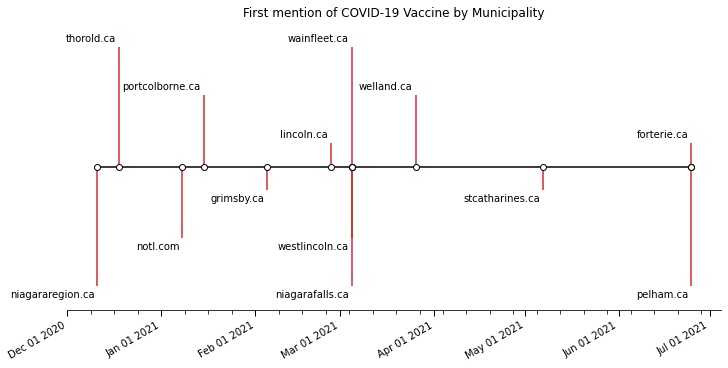

In [ ]:
# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.set(title="First mention of COVID-19 Vaccine by Municipality")

ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.

ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# annotate lines
for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top")

# format xaxis with 1 month intervals
ax.tick_params(which='major', width=1.00, length=6)
ax.tick_params(which='minor', width=0.75, length=4)

#Set major ticks monthly
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

#Set minor ticks every Monday of the month
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d %Y"))


#Need to do this because otherwise "Dec 01 2020" doesn't show up as first tick
#alternatively, can do: #ax.set_xmargin(0.1) but it looks worse.
ax.set_xticks([737760.0, 737791.0, 737822.0, 737850.0, 737881.0, 737911.0, 737942.0, 737972.0], 
              [Text(737760.0, 0, 'Dec 01 2020'), Text(737791.0, 0, 'Jan 01 2021'), Text(737822.0, 0, 'Feb 01 2021'), 
               Text(737850.0, 0, 'Mar 01 2021'), Text(737881.0, 0, 'Apr 01 2021'), Text(737911.0, 0, 'May 01 2021'), 
               Text(737942.0, 0, 'Jun 01 2021'), Text(737972.0, 0, 'Jul 01 2021')])
ax.minorticks_on() #ax.set_xticks turns off minor ticks, so turn them back on
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
for area in ["left", "top", "right"]: 
  ax.spines[area].set_visible(False)

ax.margins(y=0.1)
plt.show()